In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,  Dataset
from torch.autograd import Variable
from torch import FloatTensor
from PIL import Image
import matplotlib.pyplot as plt
import itertools
import random
import time, datetime
import sys, os
import numpy as np
import glob
import zipfile

In [0]:
#files=['ae_photos', "apple2orange" , "summer2winter_yosemite" , "horse2zebra", "monet2photo","cezanne2photo","ukiyoe2photo","vangogh2photo","maps","cityscapes","facades","iphone2dslr_flower","ae_photos"]
dataset_dir = './apple2orange'
if not os.path.exists(dataset_dir):
  !wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
  with zipfile.ZipFile("apple2orange.zip","r") as zip_ref:
      zip_ref.extractall("")

--2019-12-12 09:20:28--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘apple2orange.zip’

apple2orange.zip    100%[===================>]  74.82M  15.3MB/s    in 5.8s    

2019-12-12 09:20:35 (12.8 MB/s) - ‘apple2orange.zip’ saved [78456409/78456409]



In [0]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [0]:
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().detach().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

class Logger():
    def __init__(self, n_epochs, batches_epoch):
        #self.viz = Visdom()
        self.n_epochs = n_epochs
        self.batches_epoch = batches_epoch
        self.epoch = 1
        self.batch = 1
        self.prev_time = time.time()
        self.mean_period = 0
        self.losses = {}
        self.loss_windows = {}
        self.image_windows = {}


    def log(self, losses=None, images=None):
        self.mean_period += (time.time() - self.prev_time)
        self.prev_time = time.time()

        sys.stdout.write('\rEpoch %03d/%03d [%04d/%04d] -- ' % (self.epoch, self.n_epochs, self.batch, self.batches_epoch))

        for i, loss_name in enumerate(losses.keys()):
            if loss_name not in self.losses:
                self.losses[loss_name] = losses[loss_name].data[0]
            else:
                self.losses[loss_name] += losses[loss_name].data[0]

            if (i+1) == len(losses.keys()):
                sys.stdout.write('%s: %.4f -- ' % (loss_name, self.losses[loss_name]/self.batch))
            else:
                sys.stdout.write('%s: %.4f | ' % (loss_name, self.losses[loss_name]/self.batch))

        batches_done = self.batches_epoch*(self.epoch - 1) + self.batch
        batches_left = self.batches_epoch*(self.n_epochs - self.epoch) + self.batches_epoch - self.batch 
        sys.stdout.write('ETA: %s' % (datetime.timedelta(seconds=batches_left*self.mean_period/batches_done)))

        # Draw images
        for image_name, tensor in images.items():
            if image_name not in self.image_windows:
                self.image_windows[image_name] = self.viz.image(tensor2image(tensor.data), opts={'title':image_name})
            else:
                self.viz.image(tensor2image(tensor.data), win=self.image_windows[image_name], opts={'title':image_name})

        # End of epoch
        if (self.batch % self.batches_epoch) == 0:
            # Plot losses
            for loss_name, loss in self.losses.items():
                if loss_name not in self.loss_windows:
                    self.loss_windows[loss_name] = self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), 
                                                                    opts={'xlabel': 'epochs', 'ylabel': loss_name, 'title': loss_name})
                else:
                   self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), win=self.loss_windows[loss_name], update='append')
                # Reset losses for next epoch
                self.losses[loss_name] = 0.0

            self.epoch += 1
            self.batch = 1
            sys.stdout.write('\n')
        else:
            self.batch += 1

class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

def plot_result(real_A, real_B, fake_A, fake_B, epoch):
    fig, axs = plt.subplots(2, 2,  figsize=(7,7))
    fig.suptitle('Epoch %d' % epoch)
    axs[0, 0].imshow(tensor2image(real_A).transpose(1,2,0))
    axs[0, 1].imshow(tensor2image(fake_B).transpose(1,2,0))
    axs[1, 0].imshow(tensor2image(real_B).transpose(1,2,0))
    axs[1, 1].imshow(tensor2image(fake_A).transpose(1,2,0))
    axs[0, 0].set_title('Real A')
    axs[0, 0].axis('off')
    axs[0, 1].set_title('Fake A')
    axs[0, 1].axis('off')
    axs[1, 0].set_title('Real B')
    axs[1, 0].axis('off')
    axs[1, 1].set_title('Fake B')
    axs[1, 1].axis('off')
    plt.show()

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

----------Start training-----------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch[0/200][500/1019]	 | 	Loss_G: 8.43,	Loss_D_A: 0.43,	Loss_D_B: 0.24


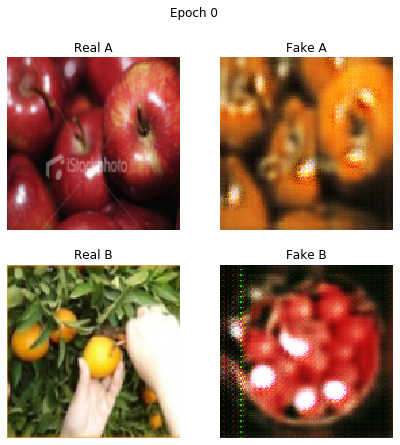

Epoch[1/200][500/1019]	 | 	Loss_G: 6.22,	Loss_D_A: 0.64,	Loss_D_B: 0.26


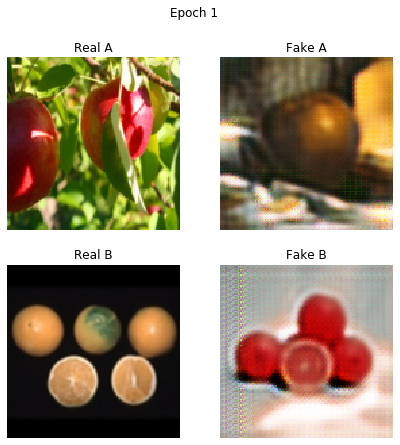

In [0]:
epoch = 0 
epochs = 200
batchSize = 1
dataroot = './apple2orange'
lr = 0.0002
decay_epoch = 100
size = 128
input_nc = 3
output_nc = 3
cuda = 'store_true'
n_gpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and n_gpu > 0) else "cpu")

###### Definition of variables ######
# Networks
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)
netD_A = Discriminator(input_nc).to(device)
netD_B = Discriminator(output_nc).to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(itertools.chain(netD_A.parameters(), netD_B.parameters()), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(epochs, epoch, decay_epoch).step)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=LambdaLR(epochs, epoch, decay_epoch).step)

# Inputs & targets memory allocation
real_label = 1
fake_label = 0
input_A = FloatTensor(batchSize, input_nc, size, size).to(device)
input_B = FloatTensor(batchSize, output_nc, size, size).to(device)
target_real = torch.full((batchSize,), real_label, device=device)
target_fake = torch.full((batchSize,), fake_label, device=device)


fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader

# transform_ = transforms.Compose(
#                 [transforms.RandomHorizontalFlip(),
#                 transforms.Resize((load_height, load_width)),
#                 transforms.RandomCrop((crop_height,crop_width)),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])


transforms_ = [ #transforms.Resize(int(size*1.12), Image.BICUBIC), 
                transforms.Resize(size), 
                #transforms.RandomCrop(size), 
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]

dataloader = DataLoader(ImageDataset(dataroot, transforms_=transforms_, unaligned=True), batch_size=batchSize, shuffle=True, num_workers=2)

###### Training ######

print('----------Start training-----------')
for epoch in range(epoch, epochs):
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = input_A.copy_(batch['A'])
        real_B = input_B.copy_(batch['B'])

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        ###################################

        ###### Discriminator B ######
        optimizer_D.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D.step()
        ###################################

        if(i==500):
            print("Epoch[%d/%3d][%2d/%d]\t | \tLoss_G: %.2f,\tLoss_D_A: %.2f,\tLoss_D_B: %.2f" % (epoch, epochs, i, len(dataloader), loss_G.item(),loss_D_A.item(), loss_D_B.item()))
            
    #Plot result after each epoch
    plot_result(real_A, real_B, fake_A, fake_B, epoch)
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D.step()

    # Save models checkpoints
#    torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
#    torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
#    torch.save(netD_A.state_dict(), 'output/netD_A.pth')
#    torch.save(netD_B.state_dict(), 'output/netD_B.pth')
###################################